In [1]:
import pandas as pd
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
import datetime

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# for results
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

pd.set_option("display.max_rows", 10)

In [2]:
# import DNN & initial setting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [3]:
# load data
division = 'm'  # s or m (s = small-sized meeting room, m = medium-sized seminar room)

# session 1
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess1\P=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess1\P=*.csv')
l.sort()

df_fea_sess1 = []
for i in l:
    df_fea_sess1.append(pd.read_csv(i, header=None))

# session 2
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess2\P=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess2\P=*.csv')
l.sort()

df_fea_sess2 = []
for i in l:
    df_fea_sess2.append(pd.read_csv(i, header=None))
    
# session 3
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess3\P=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess3\P=*.csv')
l.sort()

df_fea_sess3 = []
for i in l:
    df_fea_sess3.append(pd.read_csv(i, header=None))

In [4]:
l

['..\\..\\datasets\\medium-room\\sess3\\P=0.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=1.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=10.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=2.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=3.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=4.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=5.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=6.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=7.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=8.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=9.csv']

In [5]:
# In case of medium-room, bring P=10 dataset to behind

if division == 'm':
    # session 1
    temp1 = df_fea_sess1[2]
    del df_fea_sess1[2]
    df_fea_sess1.append(temp1)

    # session 2
    temp2 = df_fea_sess2[2]
    del df_fea_sess2[2]
    df_fea_sess2.append(temp2)

    # session 3
    temp3 = df_fea_sess3[2]
    del df_fea_sess3[2]
    df_fea_sess3.append(temp3)
    
    print('done.')

done.


In [6]:
# create column label (feature name)
# l(N1)_xxx(N2) >> N1: link number, N2: subcarrier number.

nof_link = 4
nof_usedsubc = 13

col_label = []

for i in range(nof_link):
    
    for j in range(nof_usedsubc):
        col_label.append('l%d_std%d' %(i+1,j+1))
        col_label.append('l%d_min%d' %(i+1,j+1))
        col_label.append('l%d_max%d' %(i+1,j+1))
        col_label.append('l%d_qtl%d' %(i+1,j+1))
        col_label.append('l%d_qtu%d' %(i+1,j+1))
        col_label.append('l%d_avg%d' %(i+1,j+1))
        col_label.append('l%d_iqr%d' %(i+1,j+1))
        
    for j in range(nof_usedsubc-1):
        col_label.append('l%d_adj%d' %(i+1,j+1))
        
    col_label.append('l%d_euc' %(i+1))
    col_label.append('l%d_rss' %(i+1))

len(col_label)

420

In [7]:
# change column label

# sess1
for i in range(len(df_fea_sess1)):
    df_fea_sess1[i].columns = col_label
    
# sess2
for i in range(len(df_fea_sess2)):
    df_fea_sess2[i].columns = col_label
    
# sess3
for i in range(len(df_fea_sess3)):
    df_fea_sess3[i].columns = col_label

In [8]:
df_fea_sess3[0]

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj5,l4_adj6,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss
0,0.608206,0.657957,0.713833,0.640223,0.575257,0.601237,0.613863,0.665459,0.713174,0.690920,...,3.618943,3.065197,1.281392,1.155273,2.162608,3.203592,2.274834,1.566753,1.254732,0.393239
1,0.558632,0.617536,0.591685,0.563507,0.521911,0.515001,0.523303,0.597528,0.630805,0.586206,...,3.696709,3.027887,1.221470,1.207575,2.186850,3.183312,2.212470,1.572496,1.303767,0.425122
2,0.592736,0.582817,0.633832,0.626803,0.585176,0.538540,0.623852,0.641619,0.638701,0.628728,...,3.674395,3.510138,1.248484,1.387625,2.770313,3.221348,2.636359,1.518210,1.370761,0.852038
3,0.666356,0.612643,0.697871,0.679729,0.648263,0.644887,0.677691,0.702409,0.711609,0.689965,...,3.634260,3.630998,1.247647,1.399262,2.861530,3.240161,2.620684,1.443801,1.317635,0.847652
4,0.619375,0.638782,0.635583,0.603459,0.546585,0.617259,0.661036,0.660677,0.683433,0.642949,...,3.660280,3.219130,1.204450,1.301821,2.304961,3.240413,2.157819,1.472491,1.292279,0.570483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.537044,0.664771,0.598528,0.604271,0.538355,0.576979,0.648574,0.625194,0.684797,0.655365,...,3.651667,3.238755,1.280219,1.256110,2.389406,3.115170,2.401649,1.392681,1.245854,0.560617
195,0.539713,0.613217,0.587085,0.576537,0.522141,0.525790,0.638952,0.629060,0.669724,0.618936,...,3.663798,3.168351,1.281291,1.300463,2.269914,3.102991,2.280982,1.498108,1.306935,0.515975
196,0.593539,0.600516,0.615549,0.582337,0.533078,0.538357,0.683304,0.627985,0.692913,0.631595,...,3.612947,3.440955,1.345388,1.346500,2.482081,3.134262,2.473267,1.460695,1.302883,0.740219
197,0.617981,0.599394,0.647435,0.592281,0.547554,0.549678,0.655069,0.661747,0.680038,0.629131,...,3.629142,3.793051,1.327250,1.422077,2.775449,3.136796,2.720833,1.348311,1.315951,0.673454


In [9]:
# Ground truth

for i in range(len(df_fea_sess1)):
    df_fea_sess1[i]['GT'] = i  # GT: ground truth
    
for i in range(len(df_fea_sess2)):
    df_fea_sess2[i]['GT'] = i  # GT: ground truth
    
for i in range(len(df_fea_sess3)):
    df_fea_sess3[i]['GT'] = i  # GT: ground truth

In [10]:
df_fea_sess1[3]

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj6,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss,GT
0,1.830603,1.873160,1.725519,1.594962,1.513311,1.417834,1.282464,1.052657,0.974200,0.959019,...,3.948070,1.619502,1.737586,3.056655,2.481858,3.216479,1.641629,2.833969,2.505928,3
1,1.653972,1.700725,1.442612,1.373765,1.360974,1.302505,1.178472,0.948451,0.962930,0.978861,...,2.887147,1.621722,1.422434,2.023871,2.392200,2.613357,1.874043,2.460489,2.458782,3
2,1.919865,1.950287,1.596515,1.595795,1.476098,1.285457,1.212172,1.040958,1.112712,1.029208,...,2.433325,1.457065,1.313497,1.668600,2.215635,2.213719,1.742178,2.388251,1.841882,3
3,2.215348,2.244203,1.977337,1.939716,1.737858,1.500368,1.274563,1.022749,1.153209,1.155699,...,3.231465,1.457090,1.636411,2.088249,2.016143,2.699968,1.494795,2.451414,2.619573,3
4,2.056869,2.179477,2.168995,2.066923,1.973254,1.829268,1.557790,1.185382,1.152784,1.106285,...,3.475257,1.680644,1.722947,2.527573,2.301586,2.812813,1.487229,2.523600,2.846565,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.910188,0.929432,0.820374,0.841888,0.818081,0.780074,0.837690,0.763892,0.778448,0.725079,...,2.053912,1.429570,1.451467,1.543837,1.651854,1.874679,1.503917,2.262251,1.437628,3
195,0.846394,0.832982,0.753228,0.761799,0.682601,0.734084,0.798138,0.713589,0.710684,0.708480,...,3.388962,1.819057,1.783210,2.688159,2.718980,3.509049,2.113260,2.388466,2.251772,3
196,0.799441,0.832479,0.716002,0.716839,0.647494,0.697313,0.753961,0.733368,0.756890,0.748847,...,4.509243,2.614164,2.072276,3.154163,3.881063,4.361751,2.650688,2.747130,2.187316,3
197,0.862368,0.973360,0.861439,0.845210,0.727936,0.765795,0.778770,0.725881,0.733296,0.758743,...,4.704748,3.276289,2.261142,2.710720,3.640153,3.909919,2.856965,3.130545,2.235205,3


In [11]:
df_sess1_tot = pd.DataFrame()
df_sess2_tot = pd.DataFrame()
df_sess3_tot = pd.DataFrame()

for i in df_fea_sess1:
    df_sess1_tot = pd.concat([df_sess1_tot, i], axis = 0)
    
for i in df_fea_sess2:
    df_sess2_tot = pd.concat([df_sess2_tot, i], axis = 0)
    
for i in df_fea_sess3:
    df_sess3_tot = pd.concat([df_sess3_tot, i], axis = 0)

In [12]:
df_sess1_tot

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj6,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss,GT
0,0.508360,0.556233,0.547783,0.554438,0.538969,0.528093,0.595343,0.578696,0.637909,0.631446,...,2.824882,1.398378,1.429693,2.379176,2.900677,2.177376,1.711222,1.581755,0.514346,0
1,0.485241,0.579260,0.549776,0.535239,0.512745,0.543510,0.614083,0.611247,0.662962,0.590504,...,2.945392,1.482271,1.529019,2.439519,2.971721,2.243851,1.673655,1.701424,0.472633,0
2,0.523973,0.615076,0.563608,0.577708,0.536653,0.565550,0.661444,0.643379,0.719187,0.600445,...,3.144561,1.535579,1.655584,2.537666,3.056356,2.314811,1.652796,1.740957,0.570579,0
3,0.521867,0.585397,0.514375,0.554391,0.509185,0.557026,0.588465,0.606894,0.623689,0.568644,...,3.027890,1.446881,1.501696,2.350605,3.039381,2.209710,1.695750,1.661805,0.603008,0
4,0.520318,0.607385,0.544917,0.574134,0.548106,0.562364,0.583918,0.614920,0.654618,0.599471,...,2.818021,1.362363,1.330560,2.080632,2.943398,2.176994,1.660822,1.575143,0.435911,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.917898,0.919850,0.856698,0.804004,0.727550,0.679315,0.650399,0.645671,0.707827,0.656676,...,4.454451,2.749956,2.607276,3.803033,2.618672,4.155710,1.962209,4.423469,3.771152,10
195,0.993171,1.055292,0.918394,0.886796,0.840524,0.783448,0.783273,0.697142,0.768202,0.650290,...,4.439517,3.112935,2.914972,3.582024,2.502279,4.593882,2.161841,4.788501,3.268520,10
196,0.913375,1.006806,1.072936,1.082991,1.013199,0.927840,0.883479,0.827988,0.818503,0.758421,...,4.656702,2.967989,2.856366,3.668633,2.768351,4.650457,2.228464,5.654283,3.655176,10
197,0.987489,1.093021,1.092624,1.122730,1.011742,0.943294,0.923651,0.845975,0.821050,0.787015,...,4.555711,2.941429,2.859348,3.872804,2.970375,4.116094,2.294561,5.577052,3.980606,10


In [13]:
# session number

df_sess1_tot['session'] = 1
df_sess2_tot['session'] = 2
df_sess3_tot['session'] = 3

In [14]:
df_sess1_tot

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss,GT,session
0,0.508360,0.556233,0.547783,0.554438,0.538969,0.528093,0.595343,0.578696,0.637909,0.631446,...,1.398378,1.429693,2.379176,2.900677,2.177376,1.711222,1.581755,0.514346,0,1
1,0.485241,0.579260,0.549776,0.535239,0.512745,0.543510,0.614083,0.611247,0.662962,0.590504,...,1.482271,1.529019,2.439519,2.971721,2.243851,1.673655,1.701424,0.472633,0,1
2,0.523973,0.615076,0.563608,0.577708,0.536653,0.565550,0.661444,0.643379,0.719187,0.600445,...,1.535579,1.655584,2.537666,3.056356,2.314811,1.652796,1.740957,0.570579,0,1
3,0.521867,0.585397,0.514375,0.554391,0.509185,0.557026,0.588465,0.606894,0.623689,0.568644,...,1.446881,1.501696,2.350605,3.039381,2.209710,1.695750,1.661805,0.603008,0,1
4,0.520318,0.607385,0.544917,0.574134,0.548106,0.562364,0.583918,0.614920,0.654618,0.599471,...,1.362363,1.330560,2.080632,2.943398,2.176994,1.660822,1.575143,0.435911,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.917898,0.919850,0.856698,0.804004,0.727550,0.679315,0.650399,0.645671,0.707827,0.656676,...,2.749956,2.607276,3.803033,2.618672,4.155710,1.962209,4.423469,3.771152,10,1
195,0.993171,1.055292,0.918394,0.886796,0.840524,0.783448,0.783273,0.697142,0.768202,0.650290,...,3.112935,2.914972,3.582024,2.502279,4.593882,2.161841,4.788501,3.268520,10,1
196,0.913375,1.006806,1.072936,1.082991,1.013199,0.927840,0.883479,0.827988,0.818503,0.758421,...,2.967989,2.856366,3.668633,2.768351,4.650457,2.228464,5.654283,3.655176,10,1
197,0.987489,1.093021,1.092624,1.122730,1.011742,0.943294,0.923651,0.845975,0.821050,0.787015,...,2.941429,2.859348,3.872804,2.970375,4.116094,2.294561,5.577052,3.980606,10,1


In [15]:
df_sess_tot = pd.DataFrame()

df_sess_tot = pd.concat([df_sess_tot,df_sess1_tot], axis = 0)
df_sess_tot = pd.concat([df_sess_tot,df_sess2_tot], axis = 0)
df_sess_tot = pd.concat([df_sess_tot,df_sess3_tot], axis = 0)

df_sess_tot

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss,GT,session
0,0.508360,0.556233,0.547783,0.554438,0.538969,0.528093,0.595343,0.578696,0.637909,0.631446,...,1.398378,1.429693,2.379176,2.900677,2.177376,1.711222,1.581755,0.514346,0,1
1,0.485241,0.579260,0.549776,0.535239,0.512745,0.543510,0.614083,0.611247,0.662962,0.590504,...,1.482271,1.529019,2.439519,2.971721,2.243851,1.673655,1.701424,0.472633,0,1
2,0.523973,0.615076,0.563608,0.577708,0.536653,0.565550,0.661444,0.643379,0.719187,0.600445,...,1.535579,1.655584,2.537666,3.056356,2.314811,1.652796,1.740957,0.570579,0,1
3,0.521867,0.585397,0.514375,0.554391,0.509185,0.557026,0.588465,0.606894,0.623689,0.568644,...,1.446881,1.501696,2.350605,3.039381,2.209710,1.695750,1.661805,0.603008,0,1
4,0.520318,0.607385,0.544917,0.574134,0.548106,0.562364,0.583918,0.614920,0.654618,0.599471,...,1.362363,1.330560,2.080632,2.943398,2.176994,1.660822,1.575143,0.435911,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1.202281,1.290801,1.271125,1.305875,1.164755,1.178365,1.393361,1.390979,1.085079,1.281914,...,3.599491,3.233487,4.721437,3.916543,5.886878,4.088313,6.122421,3.924364,10,3
195,0.722978,0.720824,0.755536,0.760434,0.756769,0.859506,0.879017,0.809056,0.723456,0.669041,...,3.853352,3.410025,5.080214,4.169576,6.019021,3.874508,6.068462,3.071311,10,3
196,1.439172,1.433734,1.375746,1.396880,1.182754,1.100798,1.080205,0.930623,0.951749,0.980427,...,3.939145,3.469200,4.786500,3.846884,5.735223,3.777857,6.277089,3.256937,10,3
197,1.687076,1.663921,1.522277,1.425893,1.212331,1.112767,1.146947,1.055635,1.047915,0.989870,...,3.470630,3.189984,4.881475,3.785914,5.302870,3.445231,5.274994,3.496227,10,3


In [16]:
# row index reset

df_sess_tot = df_sess_tot.reset_index()
df_sess_tot = df_sess_tot.drop('index', axis = 1)

df_sess_tot

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss,GT,session
0,0.508360,0.556233,0.547783,0.554438,0.538969,0.528093,0.595343,0.578696,0.637909,0.631446,...,1.398378,1.429693,2.379176,2.900677,2.177376,1.711222,1.581755,0.514346,0,1
1,0.485241,0.579260,0.549776,0.535239,0.512745,0.543510,0.614083,0.611247,0.662962,0.590504,...,1.482271,1.529019,2.439519,2.971721,2.243851,1.673655,1.701424,0.472633,0,1
2,0.523973,0.615076,0.563608,0.577708,0.536653,0.565550,0.661444,0.643379,0.719187,0.600445,...,1.535579,1.655584,2.537666,3.056356,2.314811,1.652796,1.740957,0.570579,0,1
3,0.521867,0.585397,0.514375,0.554391,0.509185,0.557026,0.588465,0.606894,0.623689,0.568644,...,1.446881,1.501696,2.350605,3.039381,2.209710,1.695750,1.661805,0.603008,0,1
4,0.520318,0.607385,0.544917,0.574134,0.548106,0.562364,0.583918,0.614920,0.654618,0.599471,...,1.362363,1.330560,2.080632,2.943398,2.176994,1.660822,1.575143,0.435911,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,1.202281,1.290801,1.271125,1.305875,1.164755,1.178365,1.393361,1.390979,1.085079,1.281914,...,3.599491,3.233487,4.721437,3.916543,5.886878,4.088313,6.122421,3.924364,10,3
6563,0.722978,0.720824,0.755536,0.760434,0.756769,0.859506,0.879017,0.809056,0.723456,0.669041,...,3.853352,3.410025,5.080214,4.169576,6.019021,3.874508,6.068462,3.071311,10,3
6564,1.439172,1.433734,1.375746,1.396880,1.182754,1.100798,1.080205,0.930623,0.951749,0.980427,...,3.939145,3.469200,4.786500,3.846884,5.735223,3.777857,6.277089,3.256937,10,3
6565,1.687076,1.663921,1.522277,1.425893,1.212331,1.112767,1.146947,1.055635,1.047915,0.989870,...,3.470630,3.189984,4.881475,3.785914,5.302870,3.445231,5.274994,3.496227,10,3


In [17]:
# data seperation for leave-one-session-out

from sklearn.model_selection import LeaveOneGroupOut

sessions = df_sess_tot['session']
y = df_sess_tot['GT']

df_sess_tot2 = df_sess_tot.drop('session', axis = 1)
df_sess_tot2 = df_sess_tot2.drop('GT', axis = 1)

X = df_sess_tot2.copy()
X

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj5,l4_adj6,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss
0,0.508360,0.556233,0.547783,0.554438,0.538969,0.528093,0.595343,0.578696,0.637909,0.631446,...,3.255593,2.824882,1.398378,1.429693,2.379176,2.900677,2.177376,1.711222,1.581755,0.514346
1,0.485241,0.579260,0.549776,0.535239,0.512745,0.543510,0.614083,0.611247,0.662962,0.590504,...,3.329217,2.945392,1.482271,1.529019,2.439519,2.971721,2.243851,1.673655,1.701424,0.472633
2,0.523973,0.615076,0.563608,0.577708,0.536653,0.565550,0.661444,0.643379,0.719187,0.600445,...,3.390512,3.144561,1.535579,1.655584,2.537666,3.056356,2.314811,1.652796,1.740957,0.570579
3,0.521867,0.585397,0.514375,0.554391,0.509185,0.557026,0.588465,0.606894,0.623689,0.568644,...,3.327382,3.027890,1.446881,1.501696,2.350605,3.039381,2.209710,1.695750,1.661805,0.603008
4,0.520318,0.607385,0.544917,0.574134,0.548106,0.562364,0.583918,0.614920,0.654618,0.599471,...,3.273700,2.818021,1.362363,1.330560,2.080632,2.943398,2.176994,1.660822,1.575143,0.435911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,1.202281,1.290801,1.271125,1.305875,1.164755,1.178365,1.393361,1.390979,1.085079,1.281914,...,3.177322,5.855425,3.599491,3.233487,4.721437,3.916543,5.886878,4.088313,6.122421,3.924364
6563,0.722978,0.720824,0.755536,0.760434,0.756769,0.859506,0.879017,0.809056,0.723456,0.669041,...,3.688230,6.062943,3.853352,3.410025,5.080214,4.169576,6.019021,3.874508,6.068462,3.071311
6564,1.439172,1.433734,1.375746,1.396880,1.182754,1.100798,1.080205,0.930623,0.951749,0.980427,...,3.616793,5.867715,3.939145,3.469200,4.786500,3.846884,5.735223,3.777857,6.277089,3.256937
6565,1.687076,1.663921,1.522277,1.425893,1.212331,1.112767,1.146947,1.055635,1.047915,0.989870,...,3.374324,5.820106,3.470630,3.189984,4.881475,3.785914,5.302870,3.445231,5.274994,3.496227


In [18]:
# from dataframe to numpy

X = X.values
y = y.values

In [19]:
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups = sessions)

3

In [20]:
# early stopping setting
early_stopping =  EarlyStopping(
                            monitor='val_mae',
                            min_delta=0,
                            patience=100,
                            verbose=1,
                            mode='auto')

2022-02-14 15:34:01.690627
Epoch 1/10000
40/40 [==============================] - 1s 9ms/step - loss: 4.7537 - mae: 1.3767 - val_loss: 0.8628 - val_mae: 0.6939
Epoch 2/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.5758 - mae: 0.5555 - val_loss: 0.5697 - val_mae: 0.5512
Epoch 3/10000
40/40 [==============================] - 0s 5ms/step - loss: 0.3983 - mae: 0.4678 - val_loss: 0.4983 - val_mae: 0.5212
Epoch 4/10000
40/40 [==============================] - 0s 5ms/step - loss: 0.3275 - mae: 0.4200 - val_loss: 0.4810 - val_mae: 0.4944
Epoch 5/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.2724 - mae: 0.3838 - val_loss: 0.4354 - val_mae: 0.4787
Epoch 6/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.2333 - mae: 0.3538 - val_loss: 0.3638 - val_mae: 0.4411
Epoch 7/10000
40/40 [==============================] - 0s 5ms/step - loss: 0.1962 - mae: 0.3252 - val_loss: 0.3491 - val_mae: 0.4309
Epoch 8/10000
40/40 [=====================

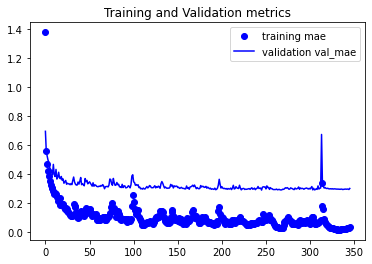

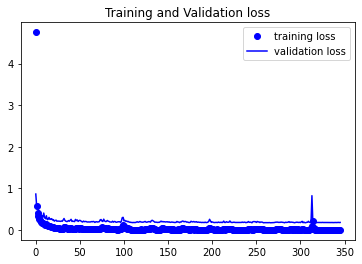

Epoch 1/10000
40/40 [==============================] - 1s 7ms/step - loss: 3.1915 - mae: 1.1335 - val_loss: 0.5806 - val_mae: 0.5515
Epoch 2/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.4665 - mae: 0.4973 - val_loss: 0.4453 - val_mae: 0.4873
Epoch 3/10000
40/40 [==============================] - 0s 5ms/step - loss: 0.3153 - mae: 0.4068 - val_loss: 0.3273 - val_mae: 0.4311
Epoch 4/10000
40/40 [==============================] - 0s 5ms/step - loss: 0.2451 - mae: 0.3617 - val_loss: 0.3090 - val_mae: 0.4113
Epoch 5/10000
40/40 [==============================] - 0s 5ms/step - loss: 0.2138 - mae: 0.3407 - val_loss: 0.3407 - val_mae: 0.4290
Epoch 6/10000
40/40 [==============================] - 0s 5ms/step - loss: 0.1857 - mae: 0.3145 - val_loss: 0.2570 - val_mae: 0.3721
Epoch 7/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.1566 - mae: 0.2859 - val_loss: 0.2491 - val_mae: 0.3627
Epoch 8/10000
40/40 [==============================] - 0s 6ms/step - 

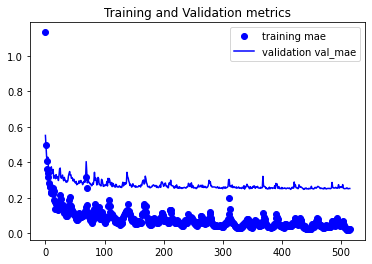

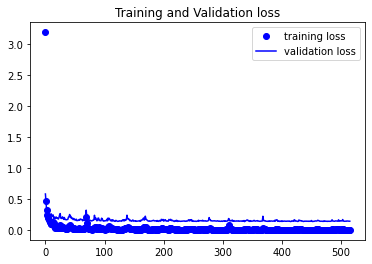

Epoch 1/10000
40/40 [==============================] - 1s 7ms/step - loss: 4.9068 - mae: 1.4193 - val_loss: 0.7048 - val_mae: 0.6140
Epoch 2/10000
40/40 [==============================] - ETA: 0s - loss: 0.5656 - mae: 0.553 - 0s 6ms/step - loss: 0.5478 - mae: 0.5424 - val_loss: 0.5625 - val_mae: 0.5338
Epoch 3/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.3921 - mae: 0.4630 - val_loss: 0.3969 - val_mae: 0.4491
Epoch 4/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.3025 - mae: 0.4038 - val_loss: 0.3865 - val_mae: 0.4342
Epoch 5/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.2554 - mae: 0.3717 - val_loss: 0.3742 - val_mae: 0.4447
Epoch 6/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.2364 - mae: 0.3577 - val_loss: 0.3250 - val_mae: 0.4230
Epoch 7/10000
40/40 [==============================] - 0s 6ms/step - loss: 0.1897 - mae: 0.3171 - val_loss: 0.3097 - val_mae: 0.3979
Epoch 8/10000
40/40 [==========

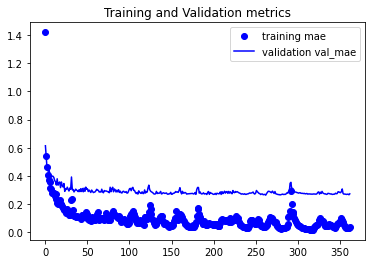

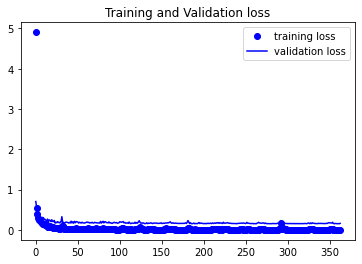

2022-02-14 15:38:44.261692


In [21]:
# learning

result_y_test=[]
result_y_pred=[]

count = 0

print(datetime.datetime.now())

for train_index, test_index in logo.split(X, y, sessions):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)
    
    # Feature standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    opt = Adam(learning_rate=0.001)

    model.compile(optimizer=opt,  
                  loss='mse', 
                  metrics=['mae'])

    # fit
    history = model.fit(X_train, y_train,  
                        batch_size=100,  
                        epochs=10000,      
                        verbose=1,       
                        validation_data=(X_val, y_val), 
                        callbacks=(early_stopping))

    # prediction
    y_pred = model.predict(X_test)
    
    # add result
    result_y_test.append(y_test)
    result_y_pred.append(y_pred)
    
    count += 1
    print(count)
    
    compare_TV(history, "mae", "val_mae")

print(datetime.datetime.now())

In [22]:
pd.DataFrame(y_pred)

,0
0,0.005669
1,0.005669
2,0.005669
3,0.005669
4,0.005669
...,...
2184,9.298397
2185,9.199242
2186,8.491396
2187,8.901321


In [23]:
print('DNN Regressor')
print('###########################')
print('Med-abs-err: ',round(median_absolute_error(np.array(result_y_test).flatten(), np.array(result_y_pred).flatten()),3))
print('Max-err: ',round(max_error(np.array(result_y_test).flatten(), np.array(result_y_pred).flatten()),4))
print('R2_score: ',round(r2_score(np.array(result_y_test).flatten(), np.array(result_y_pred).flatten()),4))
print('###########################')


DNN Regressor
###########################
Med-abs-err:  0.35
Max-err:  4.4564
R2_score:  0.9435
###########################
